In [1]:
using Distributions
using StatsPlots
using Turing

## Globe Tossing

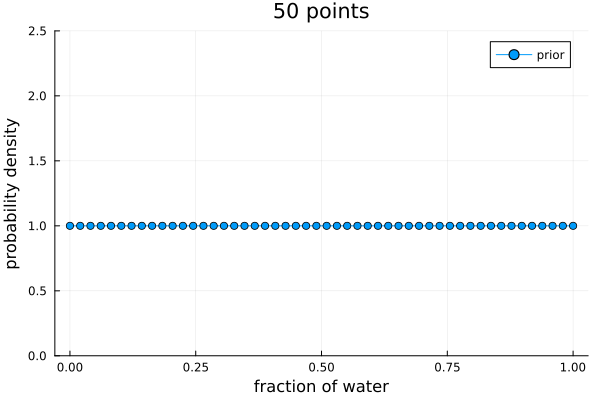

In [8]:
size = 50

θ_grid = zeros(size)
prior = zeros(size)
likelihood = zeros(size)
posterior_unstandardized = zeros(size)
posterior = zeros(size)

# uniform prior (alpha = 1, beta = 1)

for i in 1:size
    θ_grid[i] = (i-1)*1/(size-1)
    prior[i] = pdf(Beta(1,1),θ_grid[i]);
end

plot(θ_grid, prior; ylims=[0, 2.5], label = "prior", xlabel="fraction of water", ylabel="probability density", title="$size points", markershape=:circle)

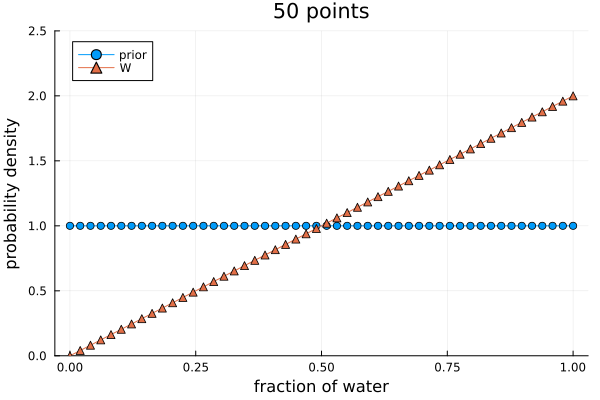

In [9]:
# first tossing: W 

for i in 1:size
    θ = θ_grid[i]
    likelihood[i] = θ # likelihood is for W (probability to get W)
    posterior_unstandardized[i] = likelihood[i] * prior[i]
end

posterior = posterior_unstandardized / (sum(posterior_unstandardized) * 1.0/size)

plot!(θ_grid, posterior; label = "W", markershape=:utriangle)


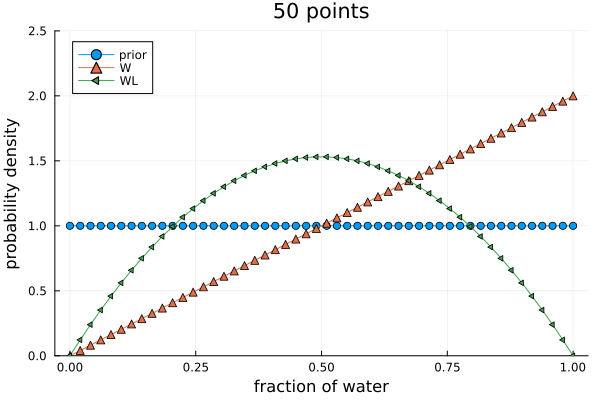

In [10]:
# second tossing: L 

prior = posterior  # the posterior from the previous step is now the prior

for i in 1:size
    θ = θ_grid[i]
    likelihood[i] = 1-θ # likelihood is for L (probability to get L)
    posterior_unstandardized[i] = likelihood[i] * prior[i]
end

posterior = posterior_unstandardized / (sum(posterior_unstandardized) * 1.0/size)

plot!(θ_grid, posterior; label = "WL", markershape=:ltriangle)


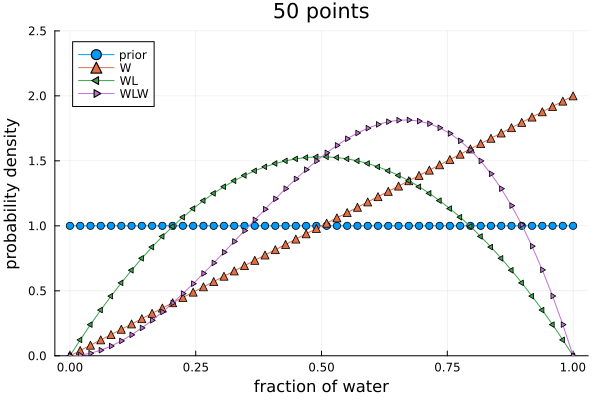

In [11]:
# third tossing: W 

prior = posterior  # the posterior from the previous step is now the prior

for i in 1:size
    θ = θ_grid[i]
    likelihood[i] = θ # likelihood is for L (probability to get L)
    posterior_unstandardized[i] = likelihood[i] * prior[i]
end

posterior = posterior_unstandardized / (sum(posterior_unstandardized) * 1.0/size)
plot!(θ_grid, posterior; label = "WLW", markershape=:rtriangle)

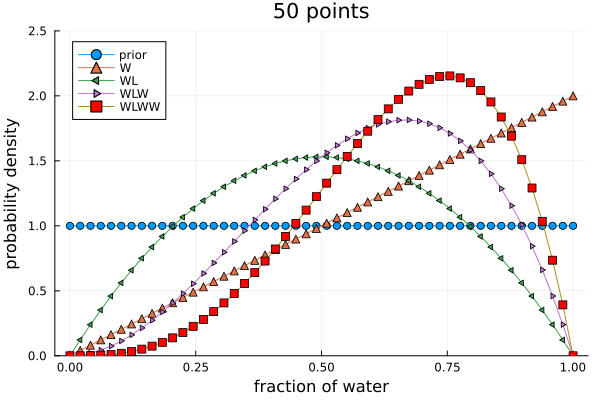

In [12]:
# fourth tossing: W 

prior = posterior  # the posterior from the previous step is now the prior

for i in 1:size
    θ = θ_grid[i]
    likelihood[i] = θ # likelihood is for L (probability to get L)
    posterior_unstandardized[i] = likelihood[i] * prior[i]
end

posterior = posterior_unstandardized / (sum(posterior_unstandardized) * 1.0/size)

plot!(θ_grid, posterior; label = "WLWW", markershape=:rect, markercolor=:red)


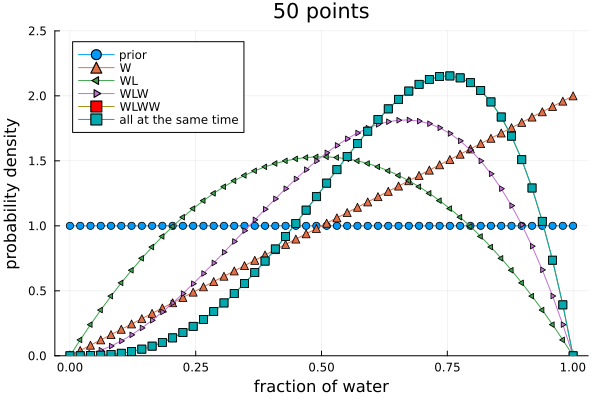

In [13]:
# Bayesian update using all the data at the same time
#  WLWW

# back to uniform prior (alpha = 1, beta = 1)

for i in 1:size
    prior[i] = pdf(Beta(1,1),θ_grid[i]);
end

for i in 1:size
    θ = θ_grid[i]
    likelihood[i] = θ*(1-θ)*θ*θ # likelihood is for WLWW (independent, so we multiply the individual likelihoods)
    posterior_unstandardized[i] = likelihood[i] * prior[i]
end

posterior = posterior_unstandardized / (sum(posterior_unstandardized) * 1.0/size)

plot!(θ_grid, posterior; label="all at the same time", markershape=:rect)

### A little more Julianic Implementation

In [ ]:
# Grid approximation
size = 50
θ_grid = range(0, 1; length=size)

# uniform prior (alpha = 1, beta = 1)
prior = pdf(Beta(1,1), θ_grid) # prior is for θ
plot(θ_grid, prior; ylims=[0, 2.5], label = "prior", xlabel="fraction of water", ylabel="probability", title="$size points", markershape=:circle)


In [ ]:
# first tossing: W 

likelihood = [ θ for θ in θ_grid ]  # likelihood is for W (probability to get W)

posterior_unstandardized = likelihood .* prior
posterior = posterior_unstandardized / (sum(posterior_unstandardized) * 1.0/size)

plot!(θ_grid, posterior; label = "W", markershape=:utriangle)


In [ ]:
# second tossing: L 

prior = posterior  # the posterior from the previous step is now the prior
likelihood = [ 1-θ for θ in θ_grid ]

posterior_unstandardized = likelihood .* prior
posterior = posterior_unstandardized / (sum(posterior_unstandardized) * 1.0/size)

plot!(θ_grid, posterior; label = "WL", markershape=:ltriangle)


In [ ]:
# third tossing: W 

prior = posterior  # the posterior from the previous step is now the prior
likelihood = [ θ for θ in θ_grid ]

posterior_unstandardized = likelihood .* prior
posterior = posterior_unstandardized / sum(posterior_unstandardized) * size

plot!(θ_grid, posterior; label = "WLW", markershape=:rtriangle)


In [ ]:
# fourth tossing: W 

prior = posterior   # the posterior from the previous step is now the prior
likelihood = [ θ for θ in θ_grid ]

posterior_unstandardized = likelihood .* prior
posterior = posterior_unstandardized / sum(posterior_unstandardized) * size

plot!(θ_grid, posterior; label = "WLWW", markershape=:rect, markercolor=:red)


In [ ]:
# Bayesian update using all the data at the same time
#  WLWW

prior = pdf(Beta(1,1), θ_grid)
#likelihood = [ pdf(Binomial(4, θ), 3) for θ in θ_grid]
likelihood = [ θ*(1-θ)*θ*θ for θ in θ_grid]

posterior_unstandardized = likelihood .* prior
posterior = posterior_unstandardized / sum(posterior_unstandardized) * size

plot!(θ_grid, posterior; markershape=:rect)


### Comparison with analytic solution

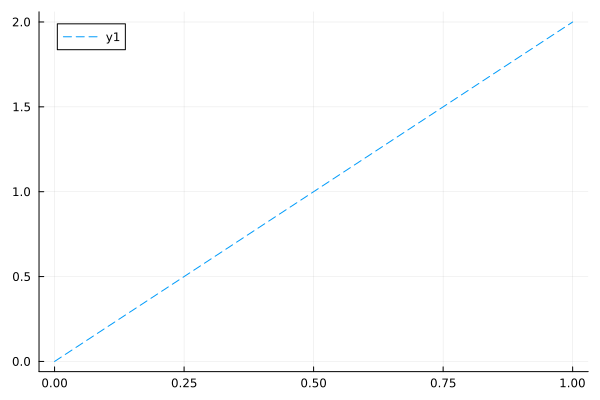

In [14]:
# We can check each of the steps using the analytic solution
# first tossing W
analytic = Beta(1+1, 1+0)  #(W = 1, L = 0)
plot(θ_grid, pdf(analytic, θ_grid); linestyle = :dash)

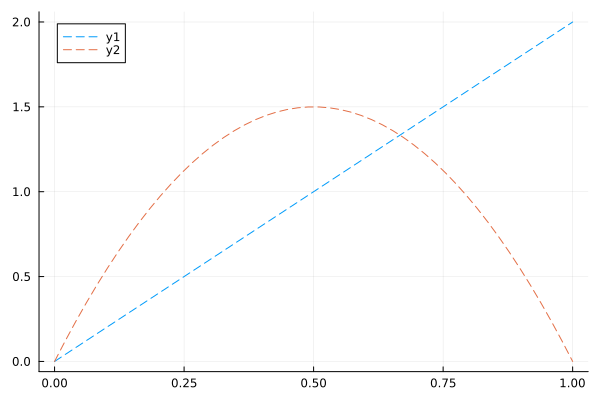

In [15]:
# second tossing L
analytic = Beta(1+1, 1+1)  #(W = 1, L = 1)
plot!(θ_grid, pdf(analytic, θ_grid); linestyle = :dash)


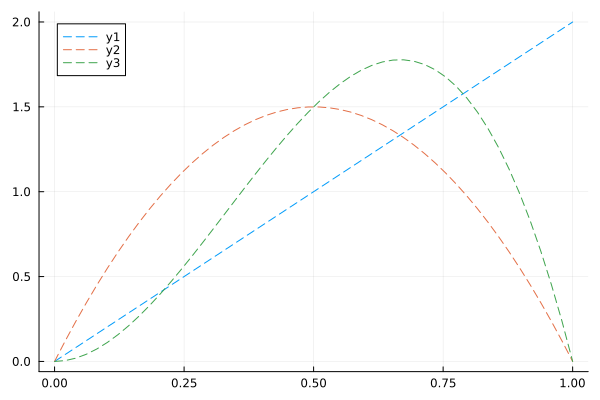

In [16]:
# third tossing W
analytic = Beta(1+2, 1+1)  #(W = 2, L = 1)
plot!(θ_grid, pdf(analytic, θ_grid); linestyle = :dash)


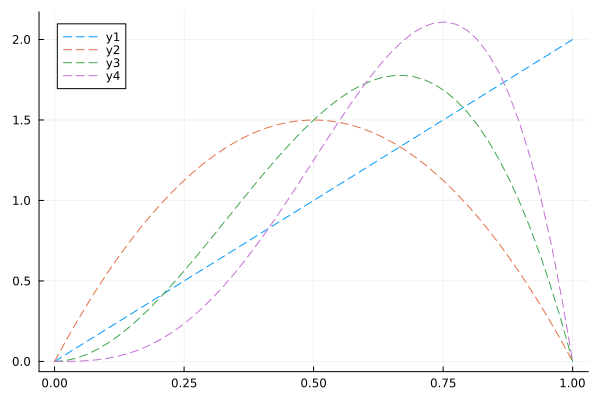

In [17]:
# fourth tossing W
analytic = Beta(1+3, 1+1) # (W = 3, L = 1)
plot!(θ_grid, pdf(analytic, θ_grid); linestyle = :dash)

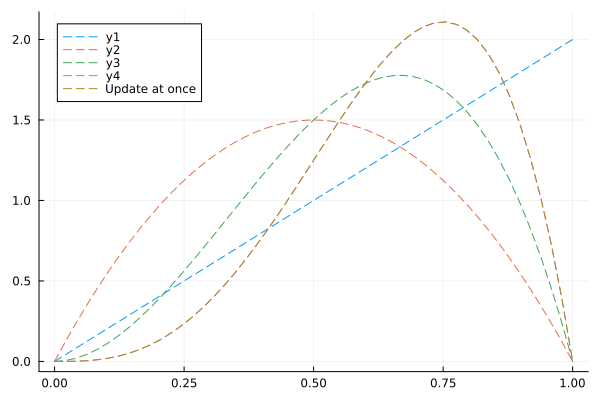

In [18]:
# Update all at the same time
analytic = Beta(1+3,1+(4-3))
plot!(θ_grid, pdf(analytic, θ_grid); label = "Update at once", linestyle = :dash)

### Using MCMC

In [19]:
# Using MCMC
@model function water_land(x, n)
    θ ~ Uniform(0, 1)  # prior # same as Beta(1,1)
    x ~ Binomial(n, θ) # likelihood
end

chain = sample(water_land(3, 4), NUTS(), 1000)
display(chain)

Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 3.2
└ @ Turing.Inference /Users/stju/.julia/packages/Turing/NQDYt/src/mcmc/hmc.jl:207
Sampling   0%|▎                                         |  ETA: 0:11:19
Sampling   1%|▍                                         |  ETA: 0:05:39
Sampling   1%|▋                                         |  ETA: 0:03:45
Sampling   2%|▊                                         |  ETA: 0:02:48
Sampling   2%|█                                         |  ETA: 0:02:14
Sampling   3%|█▏                                        |  ETA: 0:01:51
Sampling   3%|█▍                                        |  ETA: 0:01:35
Sampling   4%|█▋                                        |  ETA: 0:01:22
Sampling   4%|█▊                                        |  ETA: 0:01:13
Sampling   5%|██                                        |  ETA: 0:01:05
Sampling   5%|██▏                                       |  ETA: 0:00:59
Sampling   6%|

Chains MCMC chain (1000×13×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 4.05 seconds
Compute duration  = 4.05 seconds
parameters        = θ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

           θ    0.6649    0.1800    0.0088   412.6506   503.8559    1.0007     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           θ    0.2883    0.5426    0.6947    0.8069    0.9422


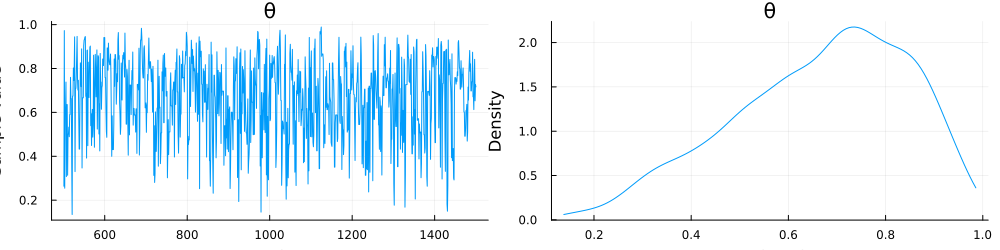

In [20]:
plot(chain)

In [ ]:
histogram(chain[:θ]; label="Turing MCMC")

### macro for help text

In [ ]:
macro h(x)
    quote
        display("text/markdown", @doc $x)
    end    
end

In [ ]:
@h pdf